# Aim

Go through all the steps of system identification for vibrations and make a better dynamic model of telescope tip-tilt aberrations based on that. This is first being built in this notebook, then it'll be incorporated into `tiptilt.py`.

## Steps

1. Make vibration data over some time.
2. Find its PSD.
3. Filter out measurement noise and curve-fit the PSD of measurement noise to find its spread.
4. Curve-fit remaining PSD to an atmosphere model.
5. Curve-fit remaining PSD to that of arbitrary vibration modes till a certain number of vibration modes has been reached or till the last one has negligible energy.
6. Construct Q based on the number of vibe modes.
7. Find AR2 state-evolution coefficients based on results of 4 and 5, and make new state-transition matrix A.
8. Run a simulation without filtering and without control action.
9. Run a simulation without filtering, but with control action.
10. Run a simulation with filtering and with control action.

In [1]:
# imports

import numpy as np
from scipy.optimize import minimize
from scipy.signal import periodogram, find_peaks
from scipy.interpolate import interp1d
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import Audio, display # for audio alerts
%matplotlib inline

# global parameter definitions

f_sampling = 1000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 10 # number of vibration modes being applied
N_vib_max = 10 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook

Applied frequencies: [102.6962911  313.3066614  153.76439871 218.29202553  82.38343201
 209.26665065 228.15976133 247.08919992  25.84879189  61.09540876]


Text(0.5,1,'Vibrations without measurement noise')

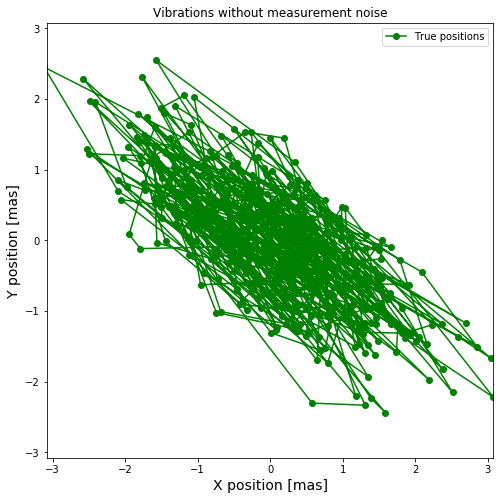

In [2]:
# step 1: making vibration data

times = np.arange(0, 0.5, 1/f_sampling)
vib_freqs    = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_phase   = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_damping  = np.random.uniform(low=1e-4, high=1e-3, size=N_vib_app) # unitless

print("Applied frequencies: " + str(vib_freqs))
'''print("Applied amplitudes: " + str(vib_amps))
print("Applied amplitude polar angles: " + str(vib_pa))
print("Applied phase offsets: " + str(vib_phase))
print("Applied damping coefficients: " + str(vib_damping))'''

# vibrations are vib_amps[i] sin/cos(vib_pa[i]) exp(-vib_damping[i] vib_freqs[i] t) exp(i*(vib_freqs[i] t - vib_phase[i])).

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

# to do: investigate why this is not equivalent to the summation formulas I had in here before.
true_positions = np.zeros((len(times),2))
    
for i in range(N_vib_app):
    y_init_of_t = vib_amps[i]*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])*np.exp(-vib_damping[i]*2*np.pi*vib_freqs[i]*times)
    x_init_of_t = np.zeros(len(times))
    positions_init = np.vstack((x_init_of_t, y_init_of_t))
    rotated_positions = np.dot(rotation_matrix(vib_pa[i]) , positions_init)
    true_positions = (true_positions + np.transpose(rotated_positions))
    
true_positions = true_positions.T
    
dx = true_positions[0]
dy = true_positions[1]

# measurement noise
dx_noisy = dx + np.random.normal(0, measurement_noise, np.size(times))
dy_noisy = dy + np.random.normal(0, measurement_noise, np.size(times))

plt.figure(figsize=(8, 8))
plt.plot(dx, dy, 'go-', label='True positions')
#plt.plot(dx_noisy, dy_noisy, 'ro-', label='Noisy positions')
plt.xlabel('X position [mas]',fontsize=14)
plt.ylabel('Y position [mas]',fontsize=14)
lim = max(np.max(np.abs(dx_noisy)), np.max(np.abs(dy_noisy)))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

plt.legend()
#plt.title('Vibrations with and without measurement noise')
plt.title('Vibrations without measurement noise')

In [3]:
# step 2: find PSD
# TODO: refactor (probably in the class implementation) so that this only operates on one mode at a time.

_, psd_tip_true = periodogram(dx, f_sampling)
freqs_tip, psd_tip = periodogram(dx_noisy, f_sampling)
_, psd_tilt_true = periodogram(dy, f_sampling)
freqs_tilt, psd_tilt = periodogram(dy_noisy, f_sampling)

(1e-07, 1)

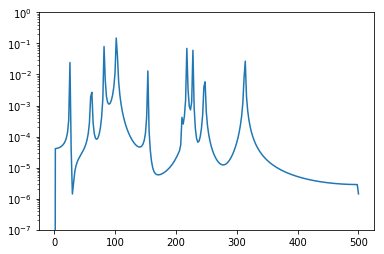

In [4]:
plt.semilogy(freqs_tip, psd_tip_true) # tilt is similar, but with slightly different peak amplitudes.
plt.ylim(1e-7,1)

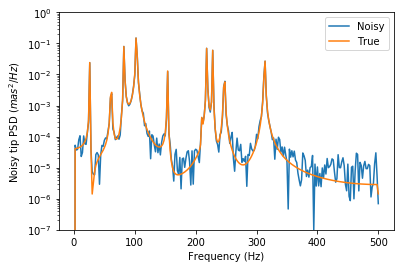

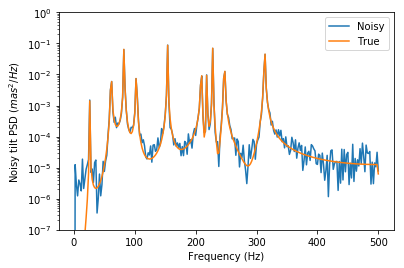

In [5]:
plt.semilogy(freqs_tip, psd_tip, label='Noisy')
plt.semilogy(freqs_tip, psd_tip_true, label='True')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tip PSD $(mas^2/Hz)$")
plt.legend()
plt.show()

plt.semilogy(freqs_tilt, psd_tilt, label='Noisy')
plt.semilogy(freqs_tilt, psd_tilt_true, label='True')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tilt PSD $(mas^2/Hz)$")
plt.legend()
plt.show()

In [6]:
# step 3: filter out measurement noise

ind = max(np.argmax(freqs_tip > f_w), np.argmax(freqs_tilt > f_w))
assert ind != 0, "didn't find a high enough frequency"
noise_psd = (psd_tip[ind:] + psd_tilt[ind:])/2
avg_measurement_power = np.mean(noise_psd)

measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
print("Recovered measurement noise: " + str(measurement_noise_recovered))
print("Percent error in measurement noise estimate: " + str(100 * np.abs(measurement_noise_recovered - measurement_noise)/measurement_noise))

psd_tip -= avg_measurement_power
psd_tilt -= avg_measurement_power

# this subtraction is problematic because it goes negative, so quick correction here. Want a better way of doing this.

for psd in [psd_tip, psd_tilt]:
    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = min(psd[psd > 0])

# squelch: removing noise by applying a smoothing filter (convolution with [0.05, 0.1, 0.7, 0.1, 0.05])
conv_peak = 0.7
assert conv_peak < 1, "convolution must have unit gain"
side = 1 - conv_peak
kernel = np.array([side/6, side/3, conv_peak, side/3, side/6])
c = kernel.size//2
psd_tip_smooth = np.convolve(psd_tip, kernel)[c:-c]
psd_tilt_smooth = np.convolve(psd_tilt, kernel)[c:-c]

# ad hoc low-pass filter
ind_cutoff = max(np.argmax(freqs_tip > f_w), np.argmax(freqs_tilt > f_w))
psd_tip_smooth[ind_cutoff:] = np.zeros(len(psd_tip_smooth) - ind_cutoff)
psd_tilt_smooth[ind_cutoff:] = np.zeros(len(psd_tilt_smooth) - ind_cutoff)

# bring the peaks back to where they were
cutoff_amp = 1e-4 # arbitrary - should replace by some function of the measurement noise
peak_ind_tip = find_peaks(psd_tip_smooth, height=cutoff_amp)[0]
peak_ind_tilt = find_peaks(psd_tilt_smooth, height=cutoff_amp)[0]
for i in peak_ind_tip:
    psd_tip_smooth[i] = psd_tip_smooth[i]/conv_peak
for i in peak_ind_tilt:
    psd_tilt_smooth[i] = psd_tilt_smooth[i]/conv_peak
psd_tip = psd_tip_smooth
psd_tilt = psd_tilt_smooth

Recovered measurement noise: 0.15577466322533037
Percent error in measurement noise estimate: 159.62443870888396


Text(0.5,1,'Recovered+filtered and true PSDs')

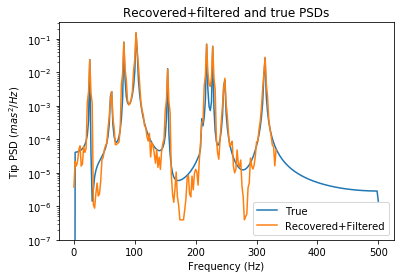

In [7]:
plt.semilogy(freqs_tilt, psd_tip_true, label='True')
plt.semilogy(freqs_tilt, psd_tip_smooth, label='Recovered+Filtered')
plt.ylim(1e-7, 2*max(psd_tip))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Tip PSD $(mas^2/Hz)$")
plt.legend()
plt.title("Recovered+filtered and true PSDs")
# filter isn't totally accurate, but it mostly picks out the peaks cleanly
# could try and LPF the noise (which I guess would be slicing in time because fft of fft) but could also just not

At this point things started not to make sense, because the curve-fit to the PSD was very inaccurate. My first attempt was following the strategy of Meimon 2010, which was a greedy strategy: assume one peak could fit the PSD, find that peak, set the PSD to the residual, and repeat until a threshold number of peaks had been crossed or the energy of a found peak was negligible.

In [8]:
# setup for step 4: curve-fitting the PSD

freq = freqs_tip # or tilt: same sampling means freq is the same

def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

def psd(pars_model):
    return periodogram(damped_harmonic(pars_model), fs=f_sampling)[1]

def log_likelihood(func, data):
    def get_ll(pars):
        pars_model, sd = pars[:-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(norm.logpdf(data, loc=data_predicted, scale=sd))
        return LL
    return get_ll

def log_psd(pars_model):
    return -np.log(psd(pars_model))

par0 = [0.55, 250, 1e-4, 0, 0.2]

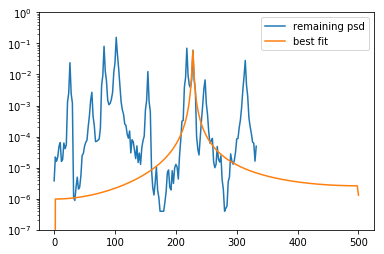

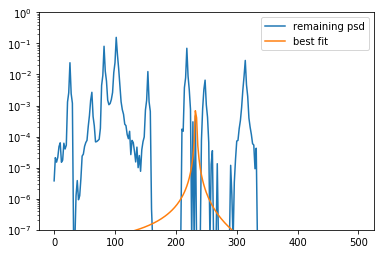

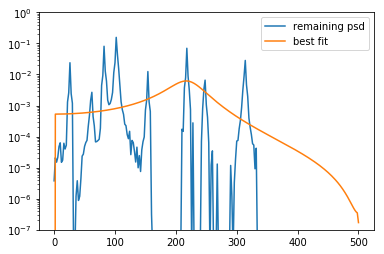

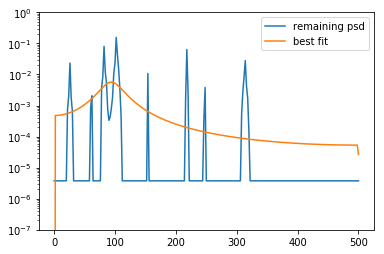

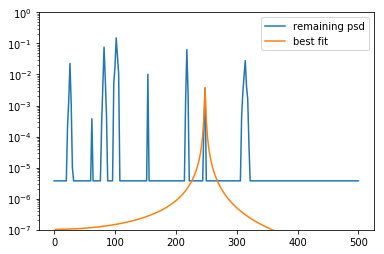

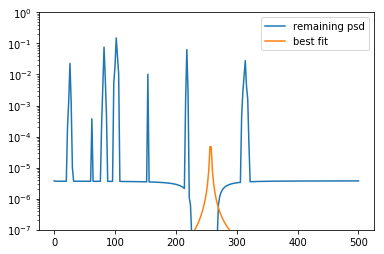

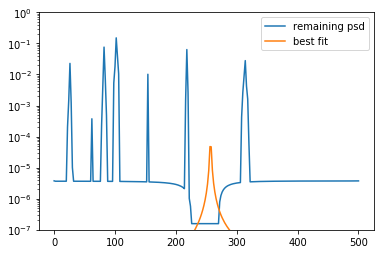

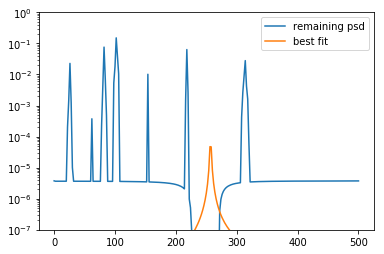

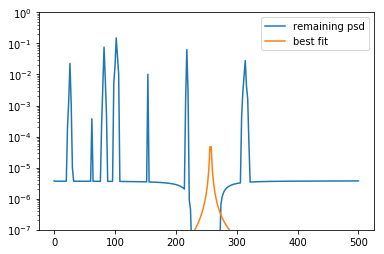

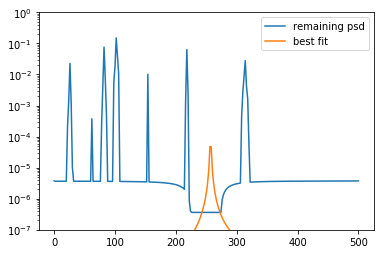

In [9]:
# old version of step 4 with the greedy strategy
PARAMS_SIZE = 4

N_vib_tip = 0
N_vib_tilt = 0
psd_tip = np.copy(psd_tip_smooth)
psd_tilt = np.copy(psd_tilt_smooth)
psd_tip_orig = np.copy(psd_tip)
psd_tilt_orig = np.copy(psd_tilt)

start_energy_tip = np.mean(psd_tip)
start_energy_tilt = np.mean(psd_tilt)

params = np.zeros((N_vib_max*2, PARAMS_SIZE))
variances = np.zeros(N_vib_max*2)

par0 = [0.5, 200, 0, np.pi, 0.2]

while N_vib_tip < N_vib_max and np.mean(psd_tip) > energy_coeff * start_energy_tip:
    psd_ll = log_likelihood(psd, psd_tip)
    output = minimize(psd_ll, par0, method='Nelder-Mead').x
    par, sd = output[:-1], output[-1]
    fit = psd(par)
    plt.semilogy(freq, psd_tip, label='remaining psd')
    plt.semilogy(freq, fit, label='best fit')
    plt.ylim(1e-7,1)
    plt.legend()
    plt.show()
    psd_tip -= fit
    for i, p in enumerate(psd_tip):
        if p < 0:
            psd_tip[i] = min(psd_tip[psd_tip > 0])
    variances[N_vib_tip] = sd**2
    params[N_vib_tip] = np.array(par)
    N_vib_tip += 1
    
while N_vib_tilt < N_vib_max and np.mean(psd_tilt) > energy_coeff * start_energy_tilt:
    psd_ll = log_likelihood(psd, psd_tilt)
    output = minimize(psd_ll, par0, method='Nelder-Mead').x
    par, sd = output[:-1], output[-1]
    psd_tilt -= psd(par)
    for i, p in enumerate(psd_tilt):
        if p < 0:
            psd_tilt[i] = min(psd_tilt[psd_tilt > 0])
    variances[N_vib_tip + N_vib_tilt] = sd**2
    params[N_vib_tip + N_vib_tilt] = np.array(par)
    N_vib_tilt += 1

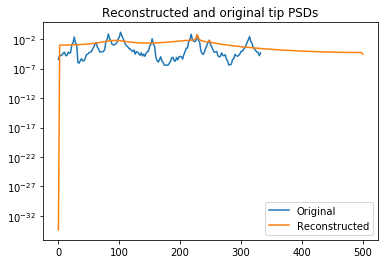

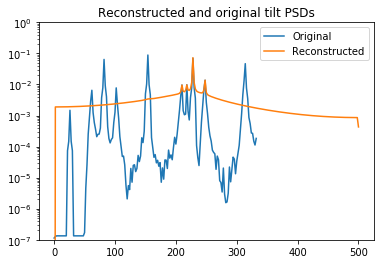

In [10]:
plt.semilogy(freq, psd_tip_orig, label="Original")
plt.semilogy(freq, sum([psd(p) for p in params[:N_vib_tip]]), label="Reconstructed")
plt.title("Reconstructed and original tip PSDs")
plt.legend()
plt.show()

plt.semilogy(freq, psd_tilt_orig, label="Original")
plt.semilogy(freq, sum([psd(p) for p in params[N_vib_tip:]]), label="Reconstructed")
plt.ylim(1e-7,1)
plt.title("Reconstructed and original tilt PSDs")
plt.legend()
plt.show()

In [11]:
params

array([[ 9.01948975e-02,  2.27859907e+02, -3.89677764e-03,
         7.16149716e+00],
       [ 6.97389636e-02,  2.32873415e+02, -1.18031850e-04,
         5.29137996e+00],
       [ 1.36554204e+01,  2.19808802e+02,  1.37692211e-01,
        -7.91824045e+01],
       [ 8.09535941e+00,  9.36514850e+01,  2.16054085e-01,
         1.65284209e+02],
       [ 2.88229603e-01,  2.47913058e+02,  2.65657845e-03,
         1.92448293e+00],
       [-5.16101769e-02,  2.56986718e+02,  3.17299883e-03,
         7.02774626e+00],
       [-5.16666439e-02,  2.56986722e+02,  3.17276943e-03,
         7.02732197e+00],
       [-5.15703785e-02,  2.56986948e+02,  3.17401203e-03,
         7.02701091e+00],
       [-5.15598068e-02,  2.56987232e+02,  3.17411731e-03,
         7.02528298e+00],
       [-5.18061591e-02,  2.56986538e+02,  3.17236680e-03,
         7.02795816e+00],
       [ 1.48651975e+01,  2.18253805e+02,  3.62585431e-01,
        -2.21261853e+02],
       [ 1.18663819e+00,  2.28011606e+02,  2.75255029e-03,
      

I pulled the above cell from a previous version of this notebook in which this type of curve-fitting wasn't working at all, but now it seems like it's at least somewhat successful. Before, it was only fitting to one peak, and that one peak didn't match up at all to any of the original PSD peaks. Here, though there are some issues with duplicate frequencies meaning it doesn't capture leading-order modes because it's doing a pointwise subtraction and the area around a peak is still counting as its own peak (which I deal with in the alternative method I came up with!), it's fitting the highest peaks pretty well.

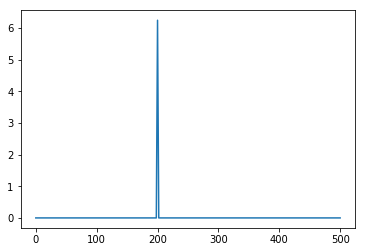

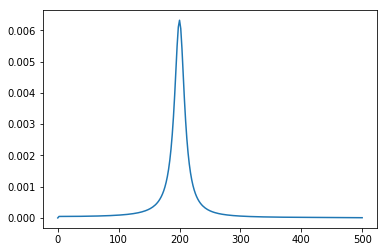

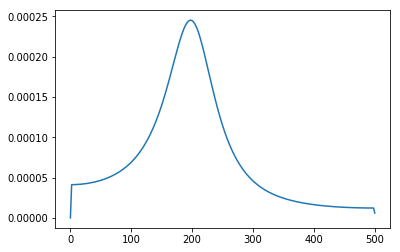

In [12]:
# intermediate: testing the effect of damping ratio on the PSD.
plt.plot(freq, psd([5, 200, 0, 0]))
plt.show()
plt.plot(freq, psd([5, 200, 0.05, 0]))
plt.show()
plt.plot(freq, psd([5, 200, 0.25, 0]))
plt.show()

Two conclusions here: not only does an increase in the damping ratio cause the expected spread, it also causes a massive hit to the magnitude. This is bad because when curve-fitting, you don't know whether the peak comes from light damping of a low amplitude or heavy damping of a higher amplitude. This is probably the reason why the earlier attempts at curve-fitting were so far off, and why what you see above misses some really high peaks in favour of redoing peaks around what's already been detected.

In [13]:
# step 4 alternate: curve-fit the PSD one peak at a time.

peak_ind_tip = find_peaks(psd_tip, height=cutoff_amp)[0]
peak_ind_tilt = find_peaks(psd_tilt, height=cutoff_amp)[0]

peak_freq_tip = freqs_tip[peak_ind_tip]
peak_freq_tilt = freqs_tilt[peak_ind_tilt] # these two should be the same but in general the modes are supposedly independent
peak_amp_tip = psd_tip[peak_ind_tip]
peak_amp_tilt = psd_tilt[peak_ind_tilt]

How do you distinguish between a peak that comes from a combination of noise and a large spread due to a relatively high damping ratio, and a peak that just happens to be right next to another one?

Put another way, if you read in the sequence of peaks "204, 206, 209, 211, 216, 218, 221, 226, 229, 231", what's your best guess as to where the leading-order peaks actually are? In this case the answer is 208 and 224.

Another question: does it even particularly matter, or can you just model it as one peak with a lot of spread and with the other peaks coming from white noise? 

Pseudocode:
```
for peak in peaks:
    if the next peak is within 4 of this one:
        add it to an array
        continue
    else
        look at your array and pick the median as the leading peak
        pick elements off the PSD from min(array) - 2 to max(array) + 2
        construct a new PSD that's the original PSD over that range and 0 elsewhere
        curve-fit to that PSD
```

In [14]:
# current version of step 4

near = np.array([])
new_psds_tip = []
for i, this_peak in enumerate(peak_ind_tip):
    near = np.append(near, this_peak)
    if i < len(peak_ind_tip)-1:
        next_peak = peak_ind_tip[i+1]
        if next_peak - this_peak <= 4:
            continue
    leading_peak = np.median(near)
    spread_ind = [int(x) for x in np.arange(max(0, min(near)-2), min(max(near)+3, len(freqs_tip)))]
    near = np.array([])
    new_psd = 1e-7 * np.ones(psd_tip.size) #random base power
    new_psd[spread_ind] = psd_tip[spread_ind]
    new_psds_tip.append(new_psd)

In [15]:
# look for this in a past commit

near = np.array([])
new_psds_tilt = []
for i, this_peak in enumerate(peak_ind_tilt):
    near = np.append(near, this_peak)
    if i < len(peak_ind_tilt)-1:
        next_peak = peak_ind_tilt[i+1]
        if next_peak - this_peak <= 4:
            continue
    leading_peak = np.median(near)
    spread_ind = [int(x) for x in np.arange(max(0, min(near)-2), min(max(near)+3, len(freqs_tilt)))]
    near = np.array([])
    new_psd = 1e-7 * np.ones(psd_tip.size) #random base power
    new_psd[spread_ind] = psd_tilt[spread_ind]
    new_psds_tilt.append(new_psd)

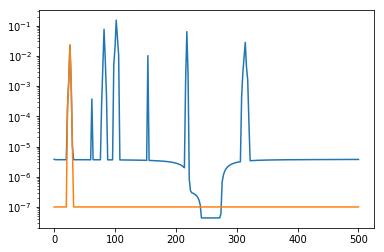

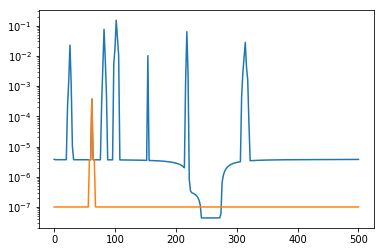

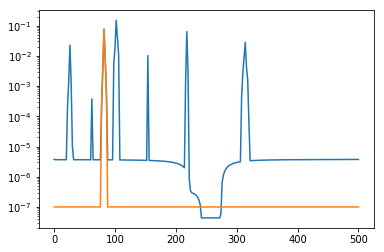

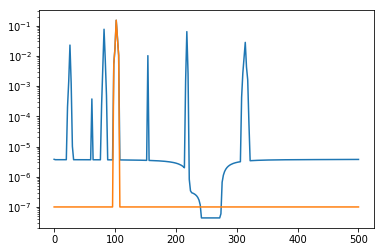

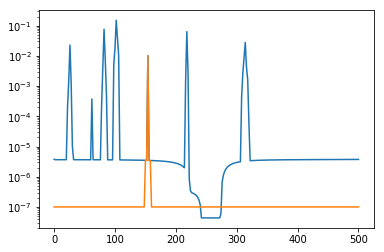

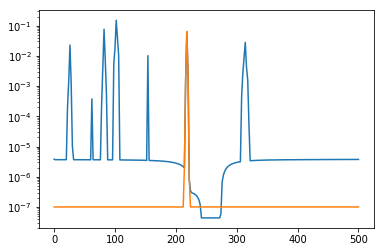

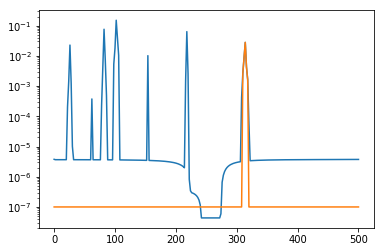

In [16]:
for p in new_psds_tip:
    plt.semilogy(freqs_tilt, psd_tip)
    plt.semilogy(freqs_tilt, p)
    plt.show()

This finds all the peaks and their spread really well!

[[ 9.01948975e-02  2.27859907e+02 -3.89677764e-03  7.16149716e+00]
 [ 6.97389636e-02  2.32873415e+02 -1.18031850e-04  5.29137996e+00]
 [ 1.36554204e+01  2.19808802e+02  1.37692211e-01 -7.91824045e+01]
 [ 8.09535941e+00  9.36514850e+01  2.16054085e-01  1.65284209e+02]
 [ 2.88229603e-01  2.47913058e+02  2.65657845e-03  1.92448293e+00]
 [-5.16101769e-02  2.56986718e+02  3.17299883e-03  7.02774626e+00]
 [-5.16666439e-02  2.56986722e+02  3.17276943e-03  7.02732197e+00]
 [-5.15703785e-02  2.56986948e+02  3.17401203e-03  7.02701091e+00]
 [-5.15598068e-02  2.56987232e+02  3.17411731e-03  7.02528298e+00]
 [-5.18061591e-02  2.56986538e+02  3.17236680e-03  7.02795816e+00]
 [ 1.48651975e+01  2.18253805e+02  3.62585431e-01 -2.21261853e+02]
 [ 1.18663819e+00  2.28011606e+02  2.75255029e-03  2.58254485e+00]
 [ 5.15064671e+00  2.36887107e+02  1.15143624e-01 -7.02336730e+01]
 [ 1.67869786e+01  2.30590691e+02  6.92442949e-01 -3.87604268e+02]
 [ 1.25881201e-01  2.30982859e+02  5.85778025e-03  2.24901020e

Text(0.5,1,'Reconstructed and true y positions')

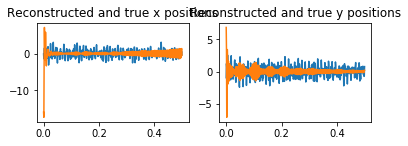

In [17]:
recon_dx = sum([damped_harmonic(params[i]) for i in range(N_vib_tip)])
recon_dy = sum([damped_harmonic(params[i]) for i in range(N_vib_tip, N_vib_tip + N_vib_tilt)])

print(params)

plt.subplot(2,2,1)
plt.plot(times, dx, label='True')
plt.plot(times, recon_dx, label='Reconstructed from PSD')
plt.title("Reconstructed and true x positions")

plt.subplot(2,2,2)
plt.plot(times, dy, label='True')
plt.plot(times, recon_dy, label='Reconstructed from PSD')
plt.title("Reconstructed and true y positions")

Text(0.5,1,'Reconstructed and true x positions')

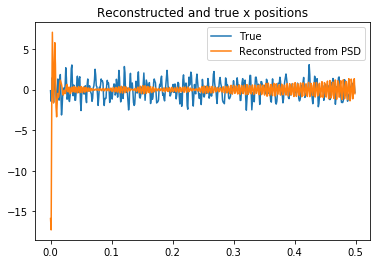

In [18]:
plt.plot(times, dx, label='True')
plt.plot(times, recon_dx, label='Reconstructed from PSD')
plt.legend()
plt.title("Reconstructed and true x positions")

In [19]:
# step 5: define Q for tip and tilt, then combine them for our eventual full dynamic system.

num_vibe_modes = N_vib_tip + N_vib_tilt
STATE_SIZE = 2*num_vibe_modes # vibe modes, vibe modes one timestep ago. dx and dy are just in measurements.
Q = np.zeros((STATE_SIZE, STATE_SIZE))
for i in range(num_vibe_modes):
    Q[2*i][2*i] = variances[i]
    
# do you set up dx and dy process noise?

In [20]:
# step 6: find AR2 state-evolution coefficients and construct A

# convention: a_ji, j is the number of the coefficient (1 or 2), i is the number of the vibe mode

A = np.zeros((STATE_SIZE, STATE_SIZE))
for i in np.arange(0, STATE_SIZE, 2):
    k = params[i][2]
    f = params[i][1]
    a_1i = 2 * np.exp(-2*k*np.pi*f/f_sampling) * np.cos(2*np.pi*f*np.sqrt(1-k**2)/f_sampling)
    a_2i = np.exp(-4*k*np.pi*f/f_sampling)
    A[i][i] = a_1i
    A[i][i+1] = a_2i
    A[i+1][i] = 1

IndexError: index 20 is out of bounds for axis 0 with size 20

In [ ]:
# step 7: set up state-space model

# all of this stuff will be moved into a DynamicSystem child class later.
# DynamicSystem isn't set up to deal with the D matrix.
# Right now, for independence, I'm going to copy over the predict and update methods and run them in a loop.


INPUT_SIZE = 2 # but this is only applied to the measurements
MEASUREMENT_SIZE = 2 # measuring dx, dy

state_init = np.random.normal(0, np.diag(Q), STATE_SIZE) 
# state starts with white process noise, otherwise it never evolves.
# state doesn't include dx and dy and has no dependence on the control input
# so if it's not started at something nonzero and allowed to evolve based on sysID
# then vibrations are just identified as zero for all time.
# this seems sketchy though.

H = np.zeros((2, STATE_SIZE))
for i in np.arange(0, 2*N_vib_tip, 2):
    H[0][i] = 1

for i in np.arange(2*N_vib_tip, STATE_SIZE, 2):
    H[1][i] = 1
    
P = np.zeros((STATE_SIZE, STATE_SIZE))
R = measurement_noise * np.identity(MEASUREMENT_SIZE)
D = np.identity(2)

def evolve():
    return (A, np.zeros((STATE_SIZE, INPUT_SIZE)))

def ext_input(state):
    return -H.dot(state)

def predict(state):
    # predicts system state at time t+dt based on system state at time t
    A, B = evolve()
    u = ext_input(state)
    state_predicted = A.dot(state) + B.dot(u)
    P_predicted = A.dot(P.dot(A.T)) + Q
    return (u, state_predicted, P_predicted)

def measure(state, u):
    return H.dot(state) - D.dot(u) # currently ignoring the loop time delay.

def update(state_predicted, P_predicted, measurement):
    error = measurement - measure(state_predicted)
    K = P_predicted.dot(H.T.dot(np.linalg.inv(H.dot(P_predicted.dot(H.T)) + R)))
    state_updated = state_predicted + K.dot(error)
    P_updated = P_predicted - K.dot(H.dot(P_predicted))
    return (state_updated, P_updated)

In [ ]:
# step 8: simulate without filtering and without applying any control input.

state = state_init
t_max = 10
dt = 1/f_sampling
t, k = 0, 1
D = np.zeros((2,2)) # I think? x only updates the vibrations, which are random around the origin.
y = np.zeros((t_max * f_sampling, INPUT_SIZE)) # y vector, not physical y.
y[0] = state_init
while t < t_max:
    u, state, _ = predict(state)
    y[k] = measure(state, u)
    k += 1
    t += dt

y = y.T
plt.plot(y[0], y[1])
plt.xlabel("x vibrations (mas)")
plt.ylabel("y vibrations (mas)")
plt.title("Uncorrected vibrations")

In [ ]:
# going to do steps 9 and 10 after I've confirmed 1-8 work